In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from poker_utils.model import plot_train_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from poker_utils.model import (analyze_embeddings, 
                               save_model_and_embeddings, evaluate_hand_hand_equity, 
                               prob_embeddings, plot_train_loss)

In [28]:
base_data = pd.read_csv("data/raw/base_hand_data.csv").set_index("hand")
blocker_data = pd.read_csv("data/raw/preflop_block_data.csv").set_index('hand')
ev_data = pd.read_csv('data/raw/ev_pca_data.csv').set_index('hand').filter(regex="play")
equity_data = pd.read_csv("data/processed/equity_totals.csv").set_index("hand")
equity_matrix = pd.read_csv("data/processed/equity_matrix.csv")


In [29]:
full_data = pd.concat(
    [base_data, 
     blocker_data, 
     equity_data, 
     ev_data], axis=1)

In [30]:
cols = [
    'suited', 'connectedness', 'pair', 'high_card', 'low_card',
    'rank_diff', 'ace', 'broadway', 'low_pair', 'medium_pair',
    'high_pair', 'broadway_score', 'suited_broadway',
    'suited_broadway_score', 'connector', 'one_gap', 'two_gap',
    'suited_connector', 'suited_one_gap', 'suited_two_gap',
    'connectedness_score', 'rank_diff_score', 'high_card_score',
    'low_card_score', 'suited_connected_score',
       
    'block_aa', 'block_kk', 'block_qq', 'block_ak', 'block_aq',
    'prem_blocker_score', 'prem_blocker_score_norm', 'block_aa_score',
    'block_kk_score',
       
    'tot_win_perc', 'high_card_win_perc',
    'one_pair_win_perc', 'two_pair_win_perc', 'three_of_a_kind_win_perc',
    'straight_win_perc', 'flush_win_perc', 'full_house_win_perc',
    'four_of_a_kind_win_perc', 'straight_flush_win_perc',
    'straight_win_potential', 'flush_win_potential', 'value_win_potential',
    'highcard_win_potential',
       
    'BB_play10', 'BB_play2', 'BB_play3', 'BB_play4', 'BB_play5', 'BB_play6',
    'BB_play7', 'BB_play8', 'BB_play9', 'D_play10', 'D_play3', 'D_play4',
    'D_play5', 'D_play6', 'D_play7', 'D_play8', 'D_play9', 'SB_play10',
    'SB_play2', 'SB_play3', 'SB_play4', 'SB_play5', 'SB_play6', 'SB_play7',
    'SB_play8', 'SB_play9', 'pos3_play10', 'pos3_play4', 'pos3_play5',
    'pos3_play6', 'pos3_play7', 'pos3_play8', 'pos3_play9', 'pos4_play10',
    'pos4_play5', 'pos4_play6', 'pos4_play7', 'pos4_play8', 'pos4_play9',
    'pos5_play10', 'pos5_play6', 'pos5_play7', 'pos5_play8', 'pos5_play9',
    'pos6_play10', 'pos6_play7', 'pos6_play8', 'pos6_play9', 'pos7_play10',
    'pos7_play8', 'pos7_play9', 'pos8_play10', 'pos8_play9', 'pos9_play10'
]

In [31]:
scaler = StandardScaler()
X = np.concat([full_data[cols].to_numpy(), equity_matrix.set_index("hand").to_numpy()],axis=1)
X_scaled = scaler.fit_transform(X)

In [32]:
X_scaled = torch.tensor(X_scaled, dtype=torch.float32)

In [41]:
class SimpleEncoder(nn.Module):
    def __init__(self, input_size=271, embedding_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(),
            nn.Linear(64,32),
            nn.LeakyReLU(),
            nn.Linear(32, embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
            nn.Linear(64,input_size)
        )
    def forward(self, x):
        x_enc = self.encoder(x)
        x_dec = self.decoder(x_enc)
        return x_enc, x_dec
    
    

In [65]:
model = SimpleEncoder()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [66]:
losses = []
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    embedding, x_recon = model(X_scaled)
    loss = criterion(X_scaled, x_recon)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

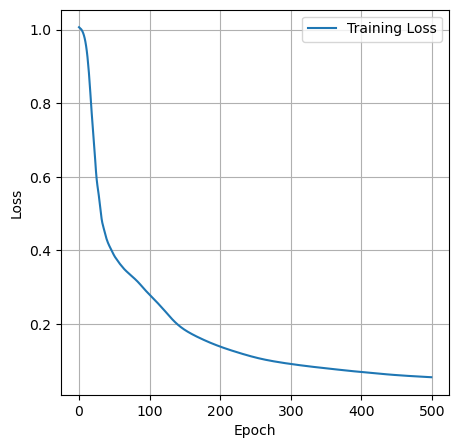

In [67]:
plt.figure(figsize=(5,5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
model.eval()
with torch.no_grad():
    embedding, x_recon = model(X_scaled)
    embeddings = F.normalize(embedding)

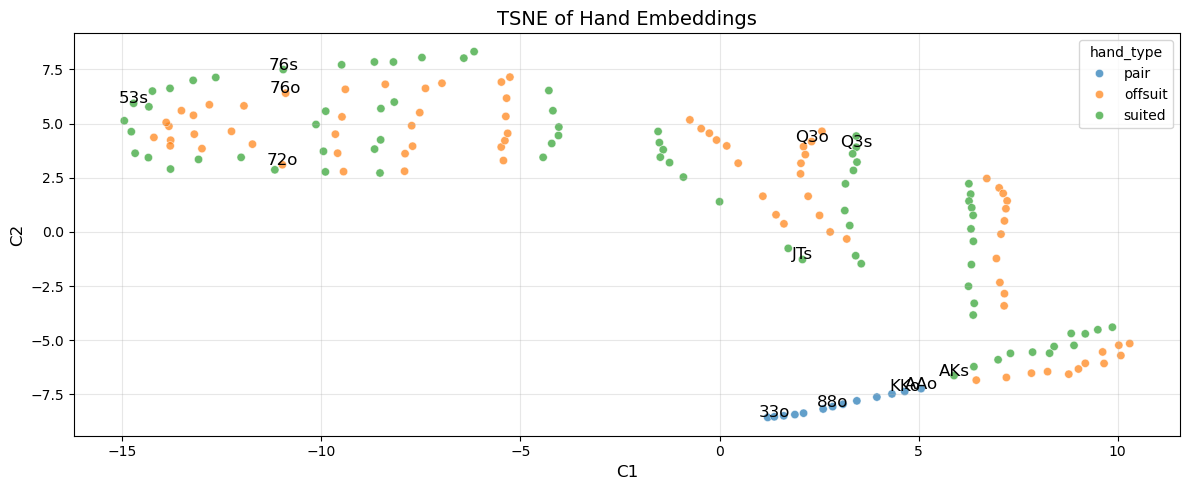

   hand         top_1         top_2         top_3       bottom_1  \
0   AAo  KKo (0.9805)  QQo (0.9573)  AKs (0.9488)  J2o (-0.1944)   
1   KKo  QQo (0.9881)  AAo (0.9805)  JJo (0.9679)  T3o (-0.1177)   
2   72o  82o (0.9795)  73o (0.9737)  72s (0.9731)  K9s (-0.1806)   
3   76s  65s (0.9633)  87s (0.9570)  76o (0.9317)  K3o (-0.4343)   
4   76o  75o (0.9732)  86o (0.9694)  85o (0.9557)  K3s (-0.4369)   
5   Q3s  Q4s (0.9943)  Q2s (0.9883)  Q5s (0.9848)  65o (-0.3290)   
6   Q3o  Q4o (0.9958)  Q5o (0.9896)  Q2o (0.9872)  54o (-0.3443)   
7   88o  99o (0.9933)  77o (0.9932)  TTo (0.9671)   K2s (0.0144)   
8   JTs  J9s (0.9464)  QJs (0.9291)  QTs (0.9098)  63o (-0.0512)   
9   33o  22o (0.9940)  44o (0.9922)  55o (0.9677)  K2s (-0.3380)   
10  AKs  AQs (0.9744)  AKo (0.9727)  AJs (0.9499)  T4o (-0.2176)   
11  53s  64s (0.9923)  42s (0.9861)  43s (0.9698)  K5s (-0.3754)   

         bottom_2       bottom_3  
0   J4o (-0.2054)  J3o (-0.2094)  
1   J3o (-0.1272)  J2o (-0.1306)  
2   K8s (-

In [69]:
similarity_df = analyze_embeddings(
    embeddings, 
    hands_of_interest=['AAo','KKo','72o','76s','76o','Q3s',"Q3o",'88o','JTs','33o',"AKs","53s"],
    hand_feature_to_color='hand_type',
    figsize=(12,5)
    )

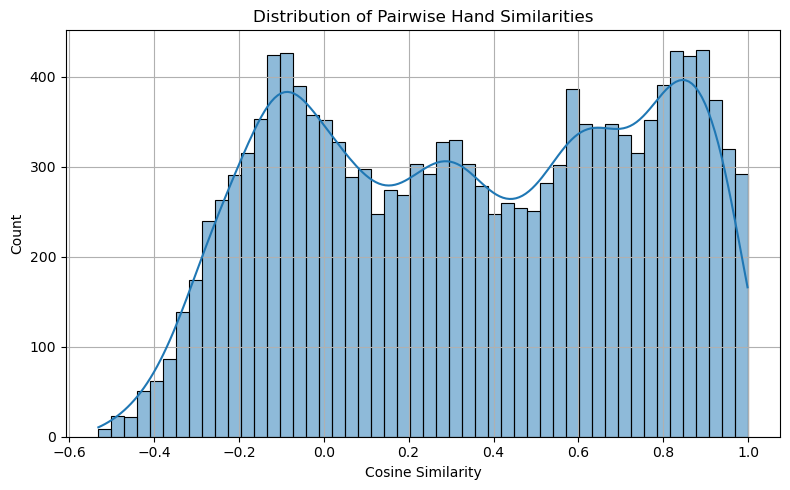

In [70]:
mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
pairwise_sims = similarity_df.where(mask)

all_similarities = pairwise_sims.stack().values

plt.figure(figsize=(8, 5))
sns.histplot(all_similarities, bins=50, kde=True)
plt.title("Distribution of Pairwise Hand Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
evaluate_hand_hand_equity(embeddings, equity_matrix.set_index('hand').to_numpy())

{'spear_corr': np.float64(0.7654304745649925), 'pval': np.float64(0.0)}

In [72]:
prob_data = pd.read_csv('data/processed/prob_data.csv')

In [73]:
prob_res = prob_embeddings(embeddings, prob_data)

In [74]:
prob_res[prob_res.attribute == 'suited_connector']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
78,suited_connector,0,0.988166,0.987342,1.000000,0.993631,0.923077,NaN
79,suited_connector,1,0.988166,1.000000,0.846154,0.916667,0.076923,NaN


In [75]:
prob_res[prob_res.attribute.str.contains("play")]

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
10,BB_play10,NaN,NaN,NaN,NaN,NaN,NaN,0.184864
11,BB_play2,NaN,NaN,NaN,NaN,NaN,NaN,0.100992
12,BB_play3,NaN,NaN,NaN,NaN,NaN,NaN,0.124241
13,BB_play4,NaN,NaN,NaN,NaN,NaN,NaN,0.137306
14,BB_play5,NaN,NaN,NaN,NaN,NaN,NaN,0.153382
15,BB_play6,NaN,NaN,NaN,NaN,NaN,NaN,0.181232
16,BB_play7,NaN,NaN,NaN,NaN,NaN,NaN,0.183462
17,BB_play8,NaN,NaN,NaN,NaN,NaN,NaN,0.163791
18,BB_play9,NaN,NaN,NaN,NaN,NaN,NaN,0.170294
19,D_play10,NaN,NaN,NaN,NaN,NaN,NaN,0.196384


In [ ]:
# prob_res.to_csv("results/prob_preflop_autoencoder.csv", index=False)
# similarity_df.reset_index().rename({"index":'hand'},axis=1).to_csv(
#     "results/sim_preflop_autoencoder.csv", index=False)

In [ ]:
# save_model_and_embeddings(
#     embeddings,
#     'preflop_embeddings_autoencoder',
#     model,
#     "preflop_autoencoder_weights"
#     )